### *CELL 1 — Markdown (what this notebook does)*

# Notebook 02 — Tributary Inflow Cleaning & Standardization (15 Tributaries)

## Purpose
This notebook standardizes and audits the 15 tributary inflow datasets used to represent Lake Victoria
catchment inflows (Objective 1).

## Key tasks
- Load all tributary CSVs from `data/raw/tributary_15_inflows/`
- Robustly parse dates (monthly series)
- Auto-detect the flow column (different naming across files)
- Standardize columns to:
  - `date` (datetime)
  - `tributary` (string)
  - `q_m3s` (float)
- Produce:
  - completeness (%) per tributary
  - missingness by year and month
  - outlier flags (do not delete; only flag)

## Outputs
Saved to `outputs/tables/`:
- `02_tributary_inventory.csv`
- `02_tributary_missingness_yearly.csv`
- `02_tributary_missingness_monthly.csv`

Saved to `outputs/figures/`:
- Coverage plot for all tributaries
- Missingness heatmap (monthly)
- Quick plot per tributary

Saved to `data/processed/`:
- `tributaries_monthly_long.csv` (long-format master dataset)

## Thesis link (Chapter 4)
These outputs support:
- Data quality and completeness of tributary inflows
- Justification for gap filling and inflow modeling choices


### *CELL 2 — Imports + paths*

In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

RAW_TRIB_DIR = PROJECT_ROOT / "data" / "raw" / "tributary_15_inflows"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR = PROJECT_ROOT / "outputs" / "figures"
TABLE_DIR = PROJECT_ROOT / "outputs" / "tables"

for folder in [PROCESSED_DIR, FIG_DIR, TABLE_DIR]:
    folder.mkdir(parents=True, exist_ok=True)


### *CELL 3 — Robust date parsing (monthly-safe, handles mixed formats)*

In [2]:
def _try_parse_dates(s: pd.Series, dayfirst: bool) -> pd.Series:
    return pd.to_datetime(s, errors="coerce", dayfirst=dayfirst, infer_datetime_format=True)


def parse_date_series(date_series: pd.Series) -> pd.DatetimeIndex:
    """
    Robust date parsing for tributary datasets.
    Works for formats like:
    - 01/01/2003
    - 1/13/2001
    - Jan-03 (if present in any tributary files)
    """
    s = date_series.astype(str).str.strip()

    dt_mdy = _try_parse_dates(s, dayfirst=False)
    dt_dmy = _try_parse_dates(s, dayfirst=True)

    if dt_mdy.isna().mean() > 0.2:
        # Try month-year format
        dt_mon = pd.to_datetime(s, errors="coerce", format="%b-%y")
        dt_mdy = dt_mdy.fillna(dt_mon)

    mdy_nat = dt_mdy.isna().mean()
    dmy_nat = dt_dmy.isna().mean()

    dt = dt_mdy if mdy_nat <= dmy_nat else dt_dmy

    if dt.isna().any():
        bad = s[dt.isna()].head(10).tolist()
        raise ValueError(f"Date parsing failed for some rows. Examples: {bad}")

    return pd.DatetimeIndex(dt)


### *CELL 4 — Flow column detection (handles your varying names)*

In [3]:
FLOW_COL_CANDIDATES = [
    "Flow_m3/s",
    "observed_flow_m3/s",
    "Flow (m3/s)",
    "flow_m3s",
    "Q_m3s",
    "Discharge_m3/s",
    "Discharge",
]


def find_flow_column(columns: List[str]) -> str:
    """Return the first matching flow column from known candidates."""
    cols = set(columns)
    for c in FLOW_COL_CANDIDATES:
        if c in cols:
            return c
    raise ValueError(
        f"Could not identify flow column. Found columns: {columns}. "
        f"Expected one of: {FLOW_COL_CANDIDATES}"
    )


### *CELL 5 — Load all tributary files into a standardized long dataframe*

In [4]:
def parse_trib_month(s: pd.Series) -> pd.Series:
    """Parse DD/MM/YYYY monthly dates to month-start timestamps."""
    dt = pd.to_datetime(
        s.astype(str).str.strip(),
        dayfirst=True,      # VERY important
        errors="coerce"
    )
    return dt.dt.to_period("M").dt.to_timestamp(how="start")


In [5]:
from pathlib import Path
import os

print("CWD:", os.getcwd())
print("Notebook sees this folder contents:", list(Path(".").iterdir())[:10])


CWD: c:\Users\Nelson\Downloads\LakeVictoria_Optimization\notebooks
Notebook sees this folder contents: [WindowsPath('01_data_inventory.ipynb'), WindowsPath('02_tributary_cleaning.ipynb'), WindowsPath('03_gap_filling.ipynb'), WindowsPath('04_inflow_model.ipynb'), WindowsPath('05_lake_water_balance.ipynb'), WindowsPath('06_baseline_rulecurve.ipynb'), WindowsPath('07_optimization.ipynb'), WindowsPath('08_flood_metrics.ipynb')]


In [6]:
from pathlib import Path

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

TRIB_DIR = PROJECT_ROOT / "data" / "raw" / "tributary_15_inflows"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("TRIB_DIR exists:", TRIB_DIR.exists())
print("Sample files:", [p.name for p in TRIB_DIR.glob("*.csv")][:5])


PROJECT_ROOT: c:\Users\Nelson\Downloads\LakeVictoria_Optimization
TRIB_DIR exists: True
Sample files: ['Awach.csv', 'Grumeti.csv', 'Kagera.csv', 'Katonga.csv', 'Magogo.csv']


In [7]:
from pathlib import Path
import pandas as pd

# ---- Detect project root correctly ----
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

TRIB_DIR = PROJECT_ROOT / "data" / "raw" / "tributary_15_inflows"

print("Using tributary directory:", TRIB_DIR)

files = sorted(TRIB_DIR.glob("*.csv"))
print(f"Found {len(files)} tributary files.")

frames = []

def parse_trib_month(s: pd.Series) -> pd.Series:
    """Parse DD/MM/YYYY monthly dates to month-start."""
    dt = pd.to_datetime(
        s.astype(str).str.strip(),
        dayfirst=True,
        errors="coerce"
    )
    return dt.dt.to_period("M").dt.to_timestamp()

for fp in files:
    df = pd.read_csv(fp)
    df.columns = [c.strip() for c in df.columns]

    df = df.rename(columns={
        "Date": "date",
        "Flow_m3/s": "q_m3s"
    })

    df["date"] = parse_trib_month(df["date"])
    df["q_m3s"] = pd.to_numeric(df["q_m3s"], errors="coerce")

    df["tributary"] = fp.stem

    frames.append(df[["date", "tributary", "q_m3s"]])

# ---- Build long table ----
trib_long = pd.concat(frames, ignore_index=True)
trib_long = trib_long.dropna(subset=["date"]).sort_values(["tributary", "date"])

print("Total rows:", len(trib_long))
trib_long.head()


Using tributary directory: c:\Users\Nelson\Downloads\LakeVictoria_Optimization\data\raw\tributary_15_inflows
Found 15 tributary files.
Total rows: 3202


,date,tributary,q_m3s
0,2003-01-01,Awach,7.544
1,2003-02-01,Awach,4.708
2,2003-03-01,Awach,4.320
3,2003-04-01,Awach,5.328
4,2003-05-01,Awach,12.884


### *CELL 6 — Enforce monthly structure + summarize frequency*

`Your tributaries are monthly (dates like 01/01/1998, 01/02/1998, etc.).`
We’ll enforce month-start indexing to avoid ambiguity.

In [8]:
def to_month_start(dt: pd.Series) -> pd.Series:
    """Convert timestamps to month-start timestamps."""
    return pd.to_datetime(dt, errors="coerce").dt.to_period("M").dt.to_timestamp(how="start")
    # equivalent: .dt.to_timestamp()  # defaults to start

trib_long["date"] = to_month_start(trib_long["date"])
trib_long = trib_long.drop_duplicates(subset=["date", "tributary"], keep="first")

trib_long.groupby("tributary")["date"].agg(["min", "max", "count"]).head(15)


,min,max,count
tributary,,,
Awach,2003-01-01,2023-12-01,252
Grumeti,2003-01-01,2017-12-01,180
Kagera,2003-01-01,2018-12-01,192
Katonga,1998-01-01,2008-12-01,132
Magogo,2003-01-01,2023-12-01,252
Mbalangeti,2003-01-01,2014-12-01,144
Migori,2003-01-01,2023-12-01,252
Mori,2003-01-01,2023-12-01,252
Nyando,1965-01-01,1993-12-01,348


### *CELL 7 — Inventory table per tributary*

In [11]:
def tributary_inventory(df: pd.DataFrame) -> pd.DataFrame:
    """Summarize coverage and missingness per tributary."""
    inv = (
        df.groupby("tributary")
        .agg(
            start=("date", "min"),
            end=("date", "max"),
            n_months=("date", "count"),
            missing_q=("q_m3s", lambda x: int(x.isna().sum())),
            missing_pct=("q_m3s", lambda x: round(100.0 * x.isna().mean(), 2)),
            mean_q=("q_m3s", "mean"),
            std_q=("q_m3s", "std"),
            min_q=("q_m3s", "min"),
            max_q=("q_m3s", "max"),
        )
        .reset_index()
        .sort_values("missing_pct", ascending=False)
    )
    return inv


trib_inv = tributary_inventory(trib_long)
trib_inv.to_csv(TABLE_DIR / "02_tributary_inventory.csv", index=False)
trib_inv.head(15)


,tributary,start,end,n_months,missing_q,missing_pct,mean_q,std_q,min_q,max_q
0,Awach,2003-01-01,2023-12-01,252,0,0.0,7.305772,3.619751,0.564400,24.112800
1,Grumeti,2003-01-01,2017-12-01,180,0,0.0,12.549459,4.603097,2.418600,23.295000
2,Kagera,2003-01-01,2018-12-01,192,0,0.0,256.999970,163.091765,18.924600,1258.224900
3,Katonga,1998-01-01,2008-12-01,132,0,0.0,3.438263,3.082225,0.007558,16.055767
4,Magogo,2003-01-01,2023-12-01,252,0,0.0,8.653703,4.015725,1.275540,23.032500
5,Mbalangeti,2003-01-01,2014-12-01,144,0,0.0,6.710822,4.506336,0.096236,18.340000
6,Migori,2003-01-01,2023-12-01,252,0,0.0,58.168514,51.932625,0.049049,229.670000
7,Mori,2003-01-01,2023-12-01,252,0,0.0,4.835384,4.080109,0.051102,19.907000
8,Nyando,1965-01-01,1993-12-01,348,0,0.0,32.030478,8.371549,18.153200,63.108900
9,Nzoia,1976-01-01,1989-12-01,168,0,0.0,88.310085,77.942291,10.207679,321.868644


### *CELL 8 — Build a complete monthly calendar and detect missing months per tributary*

`This is essential for Notebook 03 (gap filling).`

In [ ]:
def build_monthly_calendar(df: pd.DataFrame) -> pd.DatetimeIndex:
    """Create a full monthly index covering all tributary dates."""
    start = df["date"].min()
    end = df["date"].max()
    return pd.date_range(start=start, end=end, freq="MS")


monthly_idx = build_monthly_calendar(trib_long)

# Pivot to matrix (rows=months, cols=tributaries)
trib_wide = trib_long.pivot(index="date", columns="tributary", values="q_m3s")
trib_wide = trib_wide.reindex(monthly_idx)

missing_monthly = trib_wide.isna().mean().sort_values(ascending=False) * 100
missing_monthly.head(10)


tributary
Rwizi         83.192090
Katonga       81.355932
Mbalangeti    79.661017
Nzoia         76.271186
Grumeti       74.576271
Kagera        72.881356
Sio_Malaba    71.186441
Simiyu        69.491525
Yala          66.242938
Awach         64.406780
dtype: float64

### *CELL 9 — Missingness by year and month (tables)*

In [ ]:
# Missingness by year
miss_yearly = (
    trib_wide.isna()
    .groupby(trib_wide.index.year)
    .mean()
    .T
)
miss_yearly.index.name = "tributary"
miss_yearly.to_csv(TABLE_DIR / "02_tributary_missingness_yearly.csv")

# Missingness by month-of-year (seasonal gap pattern)
miss_month_of_year = (
    trib_wide.isna()
    .groupby(trib_wide.index.month)
    .mean()
    .T
)
miss_month_of_year.columns = [f"month_{m:02d}" for m in miss_month_of_year.columns]
miss_month_of_year.index.name = "tributary"
miss_month_of_year.to_csv(TABLE_DIR / "02_tributary_missingness_monthly.csv")

miss_yearly.head(15)


,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
tributary,,,,,,,,,,,,,,,,,,,,,
Awach,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumeti,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
Kagera,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
Katonga,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Magogo,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mbalangeti,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Migori,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mori,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nyando,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### *CELL 10 — Plot: coverage bars for tributaries*

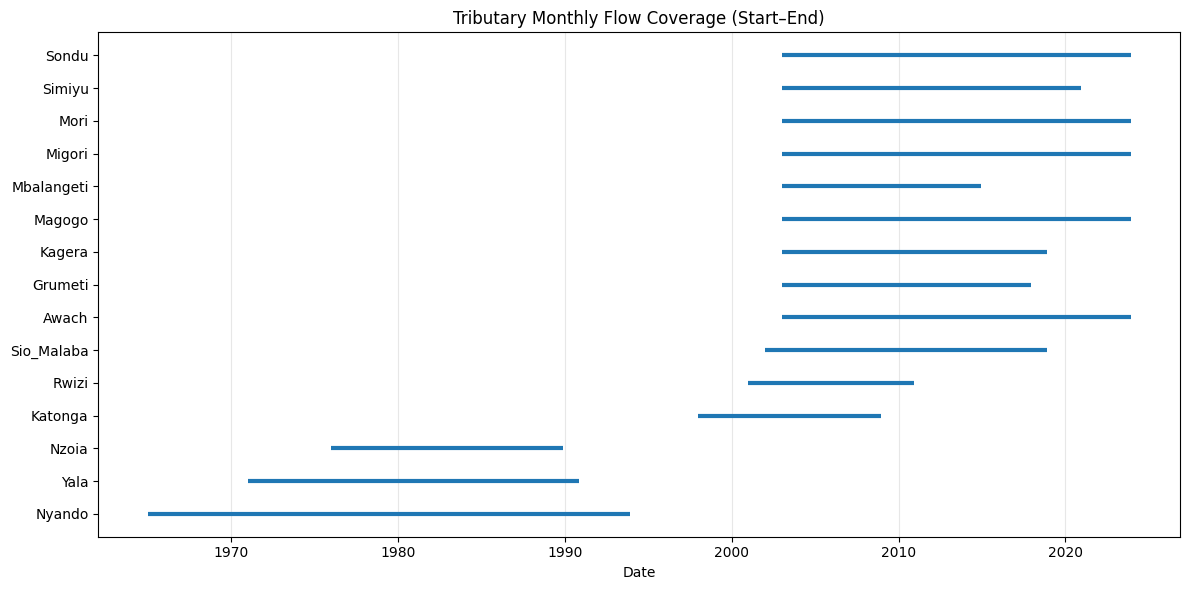

In [ ]:
def plot_tributary_coverage(inv: pd.DataFrame, outpath: Path) -> None:
    """Plot start/end coverage for each tributary."""
    inv = inv.sort_values("start").reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(12, max(6, 0.35 * len(inv))))
    y = np.arange(len(inv))

    ax.hlines(
        y=y,
        xmin=pd.to_datetime(inv["start"]),
        xmax=pd.to_datetime(inv["end"]),
        linewidth=3,
    )

    ax.set_yticks(y)
    ax.set_yticklabels(inv["tributary"])
    ax.set_xlabel("Date")
    ax.set_title("Tributary Monthly Flow Coverage (Start–End)")
    ax.grid(True, axis="x", alpha=0.3)

    fig.tight_layout()
    fig.savefig(outpath, dpi=200)
    plt.show()


plot_tributary_coverage(trib_inv, FIG_DIR / "02_tributary_coverage.png")


### *CELL 11 — Plot: missingness heatmap (monthly matrix)*

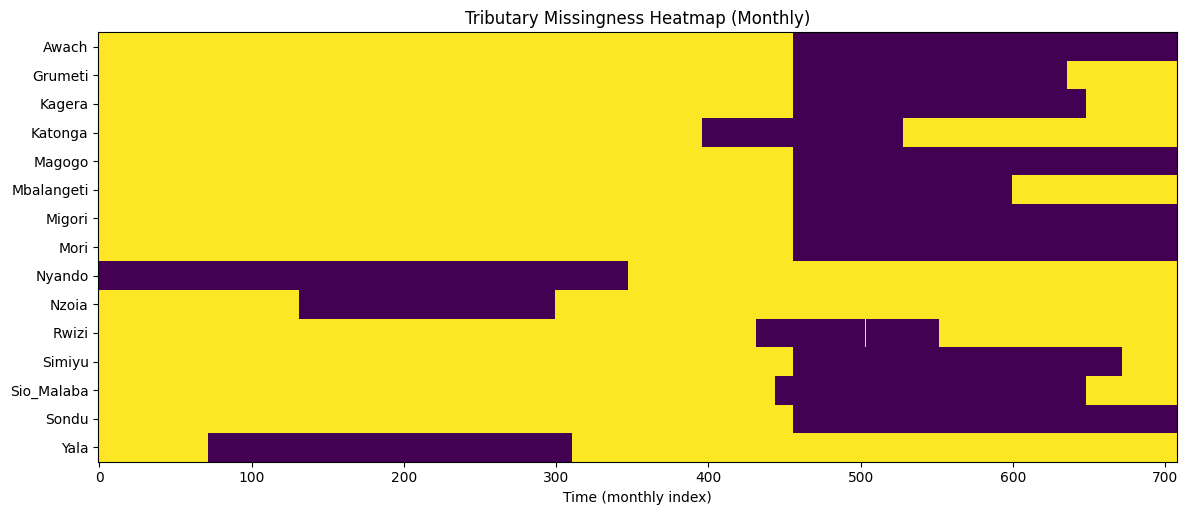

In [ ]:
def plot_missingness_heatmap_monthly(wide_df: pd.DataFrame, outpath: Path) -> None:
    """Plot missingness heatmap for tributary monthly matrix."""
    miss = wide_df.isna().T  # tributaries x time

    fig, ax = plt.subplots(figsize=(12, max(5, 0.35 * miss.shape[0])))
    ax.imshow(miss, aspect="auto", interpolation="nearest")
    ax.set_yticks(np.arange(miss.shape[0]))
    ax.set_yticklabels(miss.index)
    ax.set_title("Tributary Missingness Heatmap (Monthly)")
    ax.set_xlabel("Time (monthly index)")
    fig.tight_layout()
    fig.savefig(outpath, dpi=200)
    plt.show()


plot_missingness_heatmap_monthly(trib_wide, FIG_DIR / "02_tributary_missingness_heatmap.png")


### *CELL 12 — Quick plots per tributary (export for Chapter 4 appendix)*

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


def plot_each_tributary(wide_df: pd.DataFrame, outdir: Path) -> None:
    """Save time series plots for each tributary (skips NaNs and flags empty series)."""
    outdir.mkdir(parents=True, exist_ok=True)

    if not isinstance(wide_df.index, pd.DatetimeIndex):
        raise TypeError("wide_df.index must be a DatetimeIndex. Check your date parsing.")

    summary = []

    for trib in wide_df.columns:
        s = pd.to_numeric(wide_df[trib], errors="coerce")
        s_nonnull = s.dropna()

        fig, ax = plt.subplots(figsize=(12, 3))

        if s_nonnull.empty:
            ax.text(
                0.5, 0.5, "NO DATA AFTER CLEANING",
                ha="center", va="center", transform=ax.transAxes
            )
            ax.set_title(f"Tributary flow (monthly): {trib} (EMPTY)")
            ax.set_xlabel("Date")
            ax.set_ylabel("Flow (m³/s)")
            ax.grid(True, alpha=0.3)
            summary.append((trib, 0))
        else:
            ax.plot(s_nonnull.index, s_nonnull.values, linewidth=1)
            ax.set_title(f"Tributary flow (monthly): {trib}")
            ax.set_xlabel("Date")
            ax.set_ylabel("Flow (m³/s)")
            ax.grid(True, alpha=0.3)

            # Tight x-limits to where data exists
            ax.set_xlim(s_nonnull.index.min(), s_nonnull.index.max())
            summary.append((trib, int(s_nonnull.shape[0])))

        fig.tight_layout()
        fig.savefig(outdir / f"02_tributary_preview_{trib}.png", dpi=200)
        plt.close(fig)

    summary_df = pd.DataFrame(summary, columns=["tributary", "non_null_months"])
    summary_df = summary_df.sort_values("non_null_months")
    print(summary_df.to_string(index=False))


In [ ]:
def plot_each_tributary(wide_df: pd.DataFrame, outdir: Path) -> None:
    """Save time series plots for each tributary."""
    for trib in wide_df.columns:
        fig, ax = plt.subplots(figsize=(12, 3))
        ax.plot(wide_df.index, wide_df[trib], linewidth=1)
        ax.set_title(f"Tributary flow (monthly): {trib}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Flow (m3/s)")
        ax.grid(True, alpha=0.3)
        fig.tight_layout()
        fig.savefig(outdir / f"02_tributary_preview_{trib}.png", dpi=200)
        plt.close(fig)


plot_each_tributary(trib_wide, FIG_DIR)
print("Saved tributary preview plots to outputs/figures/")


Saved tributary preview plots to outputs/figures/


### *CELL 13 — Save processed datasets (long + wide)*

In [ ]:
trib_long.to_csv(PROCESSED_DIR / "tributaries_monthly_long.csv", index=False)
trib_wide.to_csv(PROCESSED_DIR / "tributaries_monthly_wide.csv", index=True)

print("Saved:")
print("- data/processed/tributaries_monthly_long.csv")
print("- data/processed/tributaries_monthly_wide.csv")


Saved:
- data/processed/tributaries_monthly_long.csv
- data/processed/tributaries_monthly_wide.csv
